In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle

import mlrfit as mf
import mfmodel as mfm

In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 30
mtype = 'assetcov_gics'

with open("../../mlr_fitting_private/data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       gics_hpart = pickle.load(f)

with open('../../mlr_fitting_private/data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

m = n = gics_hpart['rows']['pi'].size
part_sizes = []
for level in range(len(gics_hpart['rows']['lk'])):
    part_sizes += [gics_hpart['rows']['lk'][level].size-1]
    print(f"{level=}, {gics_hpart['rows']['lk'][level].size-1}")

Z = mf.demean_clip(C)
# features are presented in general order
unpermuted_A = Z @ Z.T / (Z.shape[1]-1)

level=0, 1
level=1, 11
level=2, 24
level=3, 69
level=4, 157
level=5, 5000


In [4]:
np.sort(np.abs(np.linalg.eigvalsh(unpermuted_A)))[::-1][:10]

array([1.80995933, 0.24351866, 0.17073495, 0.11152992, 0.08905731,
       0.080994  , 0.06320885, 0.05705067, 0.05527067, 0.05144684])

In [5]:
np.histogram(np.sort(np.abs(np.linalg.eigvalsh(unpermuted_A)))[::-1][:100], bins=8)

(array([99,  0,  0,  0,  0,  0,  0,  1]),
 array([0.02193369, 0.24543689, 0.4689401 , 0.6924433 , 0.91594651,
        1.13944971, 1.36295292, 1.58645612, 1.80995933]))

In [6]:
C.shape, unpermuted_A.shape, unpermuted_A.min(), unpermuted_A.max(), unpermuted_A.mean(), unpermuted_A.std()

((5000, 300),
 (5000, 5000),
 -0.0018394775345592505,
 0.014836883129622934,
 0.0002737358427138843,
 0.00025728376347159727)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
# GICS hierarchy
num_levels = len(gics_hpart['rows']['lk'])

In [9]:
# permute to put clusters on diagonal
Y = Z[gics_hpart["rows"]["pi"], :].T
N = Y.shape[0]

In [10]:
Y.mean(), Y.max(), Y.min(), np.median(Y)

(-0.00027599359051962765,
 1.7531290483245723,
 -0.6189932233333333,
 -0.0006269800000000001)

In [11]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(gics_hpart)

num_levels=6, num_sparsities=157
(157, 5) [  0  10  23  68 156]


In [12]:
obj_frobs = {}
obj_mle = {}

In [13]:
rs = [np.array([rank-1, 0, 0, 0, 0, 1]), np.array([14, 6, 4, 3, 2, 1])]

# $[29, 0, 0, 0, 0, 1]$

In [14]:
ranks = np.array([rank-1, 0, 0, 0, 0, 1])

# Frobenius norm

In [15]:
frob_mfm, obj_frobs[str(ranks)] = mfm.fast_frob_fit_loglikehood(unpermuted_A, Y, F_hpart, gics_hpart, ranks, printing=True, eps_ff=1e-3)

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:409: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.15413253479090114, [29  0  0  0  0  1]
itr=1, [0.15413253479090114], [29  0  0  0  0  1]
itr=1, 0.1537944954334123, [29  0  0  0  0  1], time_v_epoch=14.125530004501343, time_loss=0.46070122718811035
itr=2, 0.15379249118337154, [29  0  0  0  0  1], time_v_epoch=12.459697246551514, time_loss=0.53969407081604


In [16]:
frob_mfm.D = np.maximum(1e-7, frob_mfm.D)
frob_mfm.inv_coefficients(det=True)
obj_frobs[str(ranks)] = mfm.fast_loglikelihood_value(frob_mfm, Y[:, frob_mfm.pi_inv])
print(obj_frobs[str(ranks)])

11808.872087667582


# MLE

In [17]:
Y.shape, ranks.sum(), ranks.size, len(F_hpart['lk']), ranks

((300, 5000), 30, 6, 5, array([29,  0,  0,  0,  0,  1]))

In [18]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=150, freq=50)

Sigma0 = fitted_mfm.matrix()
print(mf.rel_diff(Sigma0, den=unpermuted_A), np.linalg.slogdet(Sigma0))
obj_mle[str(ranks)] = np.array(loglikelihoods)

t=0, obj=11795.459753006806, hist(D)=(array([4676,  295,   29]), array([2.85651968e-05, 2.75610132e-03, 5.48363745e-03, 8.21117357e-03]))
t=50, obj=11906.725432109808, hist(D)=(array([4896,  100,    4]), array([1.78915773e-05, 4.64224555e-03, 9.26659952e-03, 1.38909535e-02]))
t=100, obj=11906.869965352986, hist(D)=(array([4897,   99,    4]), array([1.79350106e-05, 4.64633254e-03, 9.27473006e-03, 1.39031276e-02]))
t=149, obj=11906.94399118941
0.16116850775166938 SlogdetResult(sign=1.0, logabsdet=-38003.39978705205)


# $[14, 6, 4, 3, 2, 1]$

In [19]:
ranks = np.array([14, 6, 4, 3, 2, 1])

# Frobenius norm

In [20]:
# Frobenius norm
frob_mfm, obj_frobs[str(ranks)] = mfm.fast_frob_fit_loglikehood(unpermuted_A, Y, F_hpart, gics_hpart, ranks, printing=True, eps_ff=1e-3)

itr=0, 0.16617119653534934, [14  6  4  3  2  1]
itr=1, [0.16617119653534934], [14  6  4  3  2  1]
itr=1, 0.164938974393478, [14  6  4  3  2  1], time_v_epoch=5.9111487865448, time_loss=0.33919501304626465
itr=2, 0.16482424552301322, [14  6  4  3  2  1], time_v_epoch=6.008795261383057, time_loss=0.33068180084228516


In [21]:
frob_mfm.D = np.maximum(1e-7, frob_mfm.D)
frob_mfm.inv_coefficients(det=True)
obj_frobs[str(ranks)] = mfm.fast_loglikelihood_value(frob_mfm, Y[:, frob_mfm.pi_inv])
print(obj_frobs[str(ranks)])

11955.956672774817


In [22]:
# LR             0.16178478761767232
# LR+D           0.1537922868665804

# MLE

In [25]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=150, freq=50, init_type="Y")

Sigma0 = fitted_mfm.matrix()
print(mf.rel_diff(Sigma0, den=unpermuted_A), np.linalg.slogdet(Sigma0))
obj_mle[str(ranks)] = np.array(loglikelihoods)

t=0, obj=11173.331524400439, hist(D)=(array([4747,  240,   13]), array([0.0001    , 0.00427417, 0.00844834, 0.01262251]))
t=50, obj=12103.677660870635, hist(D)=(array([4904,   91,    5]), array([5.71315782e-06, 4.42907933e-03, 8.85244550e-03, 1.32758117e-02]))
t=100, obj=12110.91924415567, hist(D)=(array([4901,   94,    5]), array([4.77248901e-06, 4.42447793e-03, 8.84418337e-03, 1.32638888e-02]))
t=149, obj=12113.56995629813
0.8497169166589879 SlogdetResult(sign=1.0, logabsdet=-38429.44393570121)


In [26]:
for k in obj_frobs.keys():
    print(f"{k}, {obj_mle[k][-1]-obj_frobs[k] = }, {int(obj_mle[k][-1]) - int(obj_frobs[k])}")
    obj_mle[k] = np.array(obj_mle[k])
    obj_frobs[k] = np.array(obj_frobs[k])

[29  0  0  0  0  1], obj_mle[k][-1]-obj_frobs[k] = 98.07190352182806, 98
[14  6  4  3  2  1], obj_mle[k][-1]-obj_frobs[k] = 157.61328352331293, 158


ranks='[29  0  0  0  0  1]', difference=98.07, %increase=0.83
ranks='[14  6  4  3  2  1]', difference=157.61, %increase=1.32


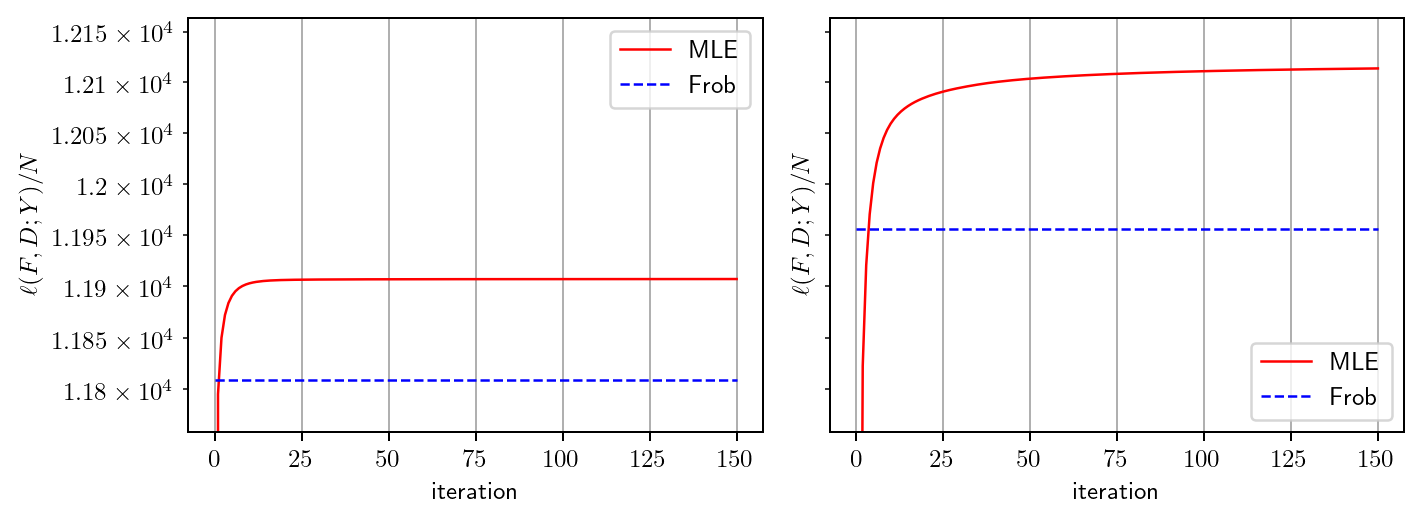

In [27]:
rs = list(obj_mle.keys())
# ll_all = [ll_factor, ll_hier]
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
ylim = [obj_frobs[str(rs[0])].max()-50, obj_mle[str(rs[1])].max() + 50]
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=180, sharey=True)
for i in range(2):
    ranks = rs[i]
    ll = obj_mle[str(rs[i])]
    print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)])/obj_frobs[str(ranks)]*100:.2f}")
    axs[i].plot(np.maximum(1, ll), color='r', lw=1, label=r"$\text{MLE}$")
    axs[i].set_xlabel('iteration')
    axs[i].hlines(obj_frobs[str(ranks)], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$", ls="--")
    axs[i].set_ylabel(r'$\ell(F, D; Y)/N$')
    axs[i].set_yscale('log')
    axs[i].set_ylim(ylim)
    axs[i].grid(True)
    axs[i].legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
# fig.suptitle("Observed data log-likelihood", fontsize=16, y=1.05)
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [28]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"mle":obj_mle,  "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open(f"outputs/em_{mtype}.pickle", 'rb') as handle:
    mlls = pickle.load(handle)

In [30]:
mlls.keys()

dict_keys(['mle', 'frob'])